## 1 Water pump prediction

### 1.1 Library insertion

In [14]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

### 1.2 Data insertion

In [15]:
training_data_value = pd.read_csv("Water-Pump-Prediction/Data/Training_set_values.csv")
training_data_label = pd.read_csv("Water-Pump-Prediction/Data/Training_set_labels.csv")
testing_data = pd.read_csv("Water-Pump-Prediction/Data/Test_set_values.csv")

# merge data
Merged_training_data = pd.merge(training_data_value,training_data_label, on="id")
All_data = pd.concat([testing_data, Merged_training_data])
All_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
1,51630,0.0,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN
2,17168,0.0,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
3,45559,0.0,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN
4,49871,500.0,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


### 1.X Support function

In [18]:
# support function for numerical data, for analysis whole dataframe
def numerical_analysis(dataFrame):
  
  # Only select numerical columns
  numerical = dataFrame.select_dtypes(include = ['int', 'Int64', 'float']).columns.tolist()
  
  #data type
  data_types = pd.DataFrame(dataFrame[numerical].dtypes,columns=['Data Type'])

  # number of data count
  count_val = pd.DataFrame(columns=['Count'])

  for row in list(dataFrame[numerical].columns.values):
      count_val.loc[row] = [dataFrame[numerical][row].count()]
    
  # missing data
  missing_data = pd.DataFrame(dataFrame[numerical].isnull().sum(),columns=['Missing Values'])

  # maximum value
  maximum_val = pd.DataFrame(columns=['Maximum'])

  for row in list(dataFrame[numerical].columns.values):
      maximum_val.loc[row] = [dataFrame[numerical][row].max()]
    
  # minimum value
  minimum_val = pd.DataFrame(columns=['Minimum'])

  for row in list(dataFrame[numerical].columns.values):
      minimum_val.loc[row] = [dataFrame[numerical][row].min()]
    
  # mean value
  mean_val= pd.DataFrame(columns=['Mean'])

  for row in list(dataFrame[numerical].columns.values):
      mean_val.loc[row] = [dataFrame[numerical][row].mean()]

  # standard deviation value
  sd_val = pd.DataFrame(columns=['Standard Deviation'])

  for row in list(dataFrame[numerical].columns.values):
      sd_val.loc[row] = [dataFrame[numerical][row].std()]

  # mode
  mode_val = pd.DataFrame(columns=['Mode'])

  for row in list(dataFrame[numerical].columns.values): 
    mode_val.loc[row] = [dataFrame[numerical][row].mode()[0]]
    mode_0 = mode_val.loc[row]
  
  # mode frequency
  count_f_list = []

  for row in numerical:
    mode_0 = dataFrame[row].mode().iat[0]
    count_f = dataFrame[row].value_counts()[mode_0]
    count_f_list.append(count_f)

  count_f_list = np.array(count_f_list)
    
  # First quartile
  IqR_1 = pd.DataFrame(columns=['1st Quartile'])

  for row in list(dataFrame[numerical].columns.values):
      IqR_1.loc[row] = [dataFrame[numerical][row].quantile(0.25)]
    
  # Median
  median = pd.DataFrame(columns=['Median'])

  for row in list(dataFrame[numerical].columns.values):
    median.loc[row] = [dataFrame[numerical][row].quantile(0.5)]
    
  # Third quartile
  IqR_3 = pd.DataFrame(columns=['3rd Quartile'])

  for row in list(dataFrame[numerical].columns.values):
    IqR_3.loc[row] = [dataFrame[numerical][row].quantile(0.75)]

  # Unique values
  unique_val = pd.DataFrame(columns=['Unique Values'])

  for row in list(dataFrame[numerical].columns.values):
    unique_val.loc[row] = [dataFrame[numerical][row].nunique()]
  
    
  # join columns 
  result = data_types.join(count_val).join(missing_data).join(unique_val).join(minimum_val).join(maximum_val).join(mean_val).join(sd_val).join(IqR_1).join(median).join(IqR_3).join(mode_val)
  
  # percentage missing
  result['Missing in %'] = (result['Missing Values'] / len(dataFrame[numerical]) *100)
  
  # alternative mode calculation
  result['Mode freq'] = count_f_list 
  result['Mode in %'] = (result['Mode freq'] / result['Count']*100).astype('float')


  # change order of columns
  result = result[['Data Type', 'Count', 'Missing Values', 'Missing in %','Unique Values', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode', 'Mode freq','Mode in %']]

  #round
  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum','Mode freq','Mode in %','Mode']] =  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode freq','Mode in %','Mode']].round(1)
  
   
  #rreturn report
  return(result)

In [19]:
num_analysis = numerical_analysis(All_data)
num_analysis

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
id,int64,74250,0,0.0,74250,37124.5,21434.3,0.0,18562.2,37124.5,55686.8,74249.0,0.0,1,0.0
amount_tsh,float64,74250,0,0.0,102,318.7,2906.8,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1
gps_height,int64,74250,0,0.0,2456,665.7,692.8,-90.0,0.0,364.0,1317.0,2777.0,0.0,25649,34.5
longitude,float64,74250,0,0.0,71870,34.1,6.6,0.0,33.1,34.9,37.2,40.3,0.0,2269,3.1
latitude,float64,74250,0,0.0,71869,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0,-0.0,2269,3.1
num_private,int64,74250,0,0.0,68,0.5,11.5,0.0,0.0,0.0,0.0,1776.0,0.0,73299,98.7
region_code,int64,74250,0,0.0,27,15.3,17.5,1.0,5.0,12.0,17.0,99.0,11.0,6608,8.9
district_code,int64,74250,0,0.0,20,5.6,9.6,0.0,2.0,3.0,5.0,80.0,1.0,15299,20.6
population,int64,74250,0,0.0,1128,180.8,471.1,0.0,0.0,25.0,215.0,30500.0,0.0,26834,36.1
construction_year,int64,74250,0,0.0,55,1298.5,952.3,0.0,0.0,1986.0,2004.0,2013.0,0.0,25969,35.0


In [10]:
def categorical_analysis(dataFrame):

    # Select categorical columns
    cat_columns = dataFrame.select_dtypes(include='object').columns.tolist()

    # Data types
    data_types = pd.DataFrame(dataFrame[cat_columns].dtypes,columns=['Data Type'])


    # Missing data
    missing_df = pd.DataFrame(dataFrame[cat_columns].isnull().sum(),columns=['Missing Values'])

    # Record counts
    records_df = pd.DataFrame(columns=['Records'])

    for col in list(dataFrame[cat_columns].columns.values):
        records_df.loc[col] = [dataFrame[cat_columns][col].count()]

    # Unique values
    unique_val = pd.DataFrame(columns=['Unique Values'])
    for col in list(dataFrame[cat_columns].columns.values):
        unique_val.loc[col] = [dataFrame[cat_columns][col].nunique()]

    # Mode
    mode_df = pd.DataFrame(columns=['Mode'])

    for col in list(dataFrame[cat_columns].columns.values):
        mode_df.loc[col] = [dataFrame[cat_columns][col].mode()[0]]

    # Mode frequency
    mode_freq_list = []
    for col in cat_columns:
        mode_val = dataFrame[col].mode().iat[0]
        freq = dataFrame[col].value_counts()[mode_val]
        mode_freq_list.append(freq)
    mode_freq_array = np.array(mode_freq_list)

    # Create data quality report
    result = data_types.join(missing_df).join(records_df).join(unique_val).join(mode_df)
    result['Mode freq'] = mode_freq_array
    result['Mode in %'] = (result['Mode freq'] / result['Records'] * 100).astype('float')
    result['Missing in %'] = (result['Missing Values'] / len(dataFrame[cat_columns]) * 100)

    # Change order of columns
    result = result[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing in %', 'Mode', 'Mode freq', 'Mode in %']]
    result[['Missing in %', 'Mode in %']] = result[['Missing in %', 'Mode in %']].round(1)

    # Return report
    return result


In [11]:
cat_analysis = categorical_analysis(All_data)
cat_analysis

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,687,0,0.0,2011-03-15,572,0.8
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2
installer,object,69718,2410,4532,6.1,DWE,21751,31.2
wpt_name,object,74248,45683,2,0.0,none,4440,6.0
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9
region,object,74250,21,0,0.0,Iringa,6599,8.9
lga,object,74250,125,0,0.0,Njombe,3128,4.2
ward,object,74250,2098,0,0.0,Igosi,386,0.5
public_meeting,object,70095,2,4155,5.6,True,63749,90.9


In [12]:
# check duplicate 
def check_duplicate(dataFrame):
  duplicates = dataFrame.duplicated(keep = 'first').sum()
  print("No. duplicates: {}".format(duplicates))
  print("Total counts: {}".format(len(dataFrame)))
  print("Duplicated in %: {}".format((duplicates/len(dataFrame))*100))

In [13]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


In [97]:
def distribution_checker (data, xlabel):
  grouped = data.groupby([xlabel, 'status_group'])['id'].count().reset_index()
  pivot = grouped.pivot_table(index = xlabel, columns = 'status_group', fill_value = 0)
  mi=pivot.columns
  mi.tolist()
  ind = pd.Index([ str(e[1])  for e in mi.tolist()])
  pivot.columns = ind
  pivot['nr_pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
  pivot['all_pumps'] = pivot['nr_pumps'].sum()
  pivot['perc_total_pumps'] =((pivot['nr_pumps']/pivot['all_pumps'])*100).round(1)
  pivot['perc_functional'] = ((pivot['functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_non_functional'] = ((pivot['non functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_functional_needs_repair'] = ((pivot['functional needs repair']/pivot['nr_pumps'])*100).round(1)
  pivot = pivot.drop(['functional', 'functional needs repair', 'non functional', 'all_pumps'], axis=1)
  return(pivot)

## 2 EDA - Preview

### 2.1 Duplication

In [57]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


### 2.X 

## 3 EDA - Data Features

### 3.1 Amount_tsh

In [60]:
num_analysis.loc[['amount_tsh']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
amount_tsh,float64,74250,0,0.0,102,318.7,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1


In [64]:
All_data['amount_tsh'].isna().sum()

0

In [65]:
All_data['amount_tsh'] = All_data['amount_tsh'].replace(0,All_data['amount_tsh'].mean())

In [68]:
All_data['amount_tsh'].mode()

0    318.685704
Name: amount_tsh, dtype: float64

The most occured value is 0 and it was over 70% in whole data. We can assume that it contains some missing value.
It could be replaced by mean values or drop this feature after experiment.

### 3.2 date_recorded

In [96]:
cat_analysis.loc[['date_recorded']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,687,0,0.0,2011-03-15,572,0.8


From the first category analysis, there is no important insight we can gain from this form. To obtain further information, we can make a filter to only year or month.

#### Recorded year

In [119]:
#create 'recorded_year' feature
temp = All_data.copy()
temp['recorded_year'] = pd.DatetimeIndex(temp['date_recorded']).year

#check the distribution of 'status_group' for the 'recorded_year' feature
recorded = distribution_checker(temp ,'recorded_year')
recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
recorded_year,,,,,
2002,1.0,0.0,100.0,0.0,0.0
2004,30.0,0.1,33.3,63.3,3.3
2011,28674.0,48.3,56.6,37.1,6.3
2012,6424.0,10.8,48.7,45.7,5.6
2013,24271.0,40.9,53.2,38.0,8.8


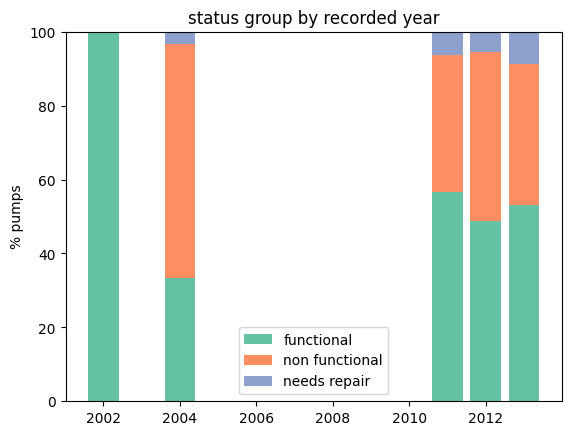

In [122]:
#plot status group by recorded year

fig, ax = plt.subplots()
labels = temp['recorded_year'].sort_values().unique()[1:]
ax.bar(labels, recorded['perc_functional'], label ='functional' ,  color = '#66c2a5')
ax.bar (labels, recorded['perc_non_functional'], label = 'non functional', bottom = recorded['perc_functional'] , color = '#fc8e62')
ax.bar(labels, recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = recorded['perc_functional'] + recorded['perc_non_functional'], color = '#8da0cb')
ax.set_title('status group by recorded year')
ax.set_ylabel('% pumps')
plt.legend()
plt.show()

The majority data are focusing between 2011 to 2013. Which is have the most of the variuos status group data.

#### Recorded month

In [124]:
#create 'recorded_year' feature
temp = All_data.copy()
temp['recorded_month'] = pd.DatetimeIndex(temp['date_recorded']).month

#check the distribution of 'status_group' for the 'recorded_year' feature
recorded = distribution_checker(temp ,'recorded_month')
recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
recorded_month,,,,,
1,6354.0,10.7,41.1,46.2,12.7
2,12402.0,20.9,55.2,37.3,7.5
3,17936.0,30.2,61.7,33.3,5.0
4,3970.0,6.7,51.6,37.3,11.0
5,336.0,0.6,60.1,36.9,3.0
6,346.0,0.6,78.0,19.4,2.6
7,6928.0,11.7,50.2,41.9,7.9
8,3364.0,5.7,51.1,41.4,7.5
9,328.0,0.6,65.2,31.7,3.0


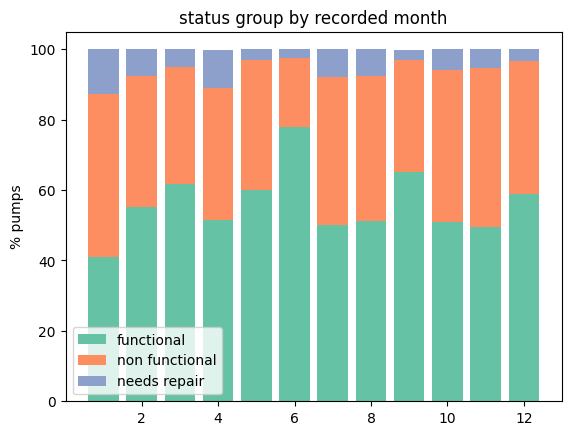

In [126]:
#plot status group by 'recorded_month'
fig, ax = plt.subplots()
labels = temp['recorded_month'].sort_values().unique()
ax.bar(labels, recorded['perc_functional'], label = 'functional' ,  color = '#66c2a5')
ax.bar (labels, recorded['perc_non_functional'], label = 'non functional', bottom = recorded['perc_functional'] , color = '#fc8e62')
ax.bar(labels, recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = recorded['perc_functional'] + recorded['perc_non_functional'], color = '#8da0cb')
ax.set_title('status group by recorded month')
ax.set_ylabel('% pumps')
plt.legend()
plt.show()

The status of most pumps recorded is in February and March and far less in May and June. The data showing a trend that with less recorded month which will contain less needs repair pump.

It seems that the functionality rates of pumps vary across different months, though this observation could be influenced by the fewer data entries recorded during these periods.

In conclusion, we may replace construction month rather than construction year because it is containing a bit more detail. We can use weather condition to category all month into 4 weather condition.

In [ ]:
All_data['month'] = pd.DatetimeIndex(All_data['date_recorded']).month

# season encoder
season_mapper = {1: 'Winter',2:'Winter', 3: 'long rain', 4: 'long rain', 5: 'long rain',6: 'long dry', 
                 7: 'long dry', 8: 'long dry', 9: 'long dry', 10: 'long dry', 11:'short rain', 12:'Winter'}
#.p feature values to scale
final_df['season']=final_df['month'].replace(season_mapper)
final_df=final_df.drop('month', axis=1)

### 3.3 Funder

In [127]:
cat_analysis.loc[['funder']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2


In [128]:
#check the distribution of status groups for the 10 most frequent funders
funder = distribution_checker(All_data, 'funder')
funder = funder.sort_values('nr_pumps', ascending= False)
funder.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
funder,,,,,
Government Of Tanzania,9084.0,16.3,41.0,51.3,7.7
Danida,3114.0,5.6,55.0,39.9,5.1
Hesawa,2202.0,3.9,42.5,47.0,10.5
Rwssp,1374.0,2.5,58.6,33.5,7.9
World Bank,1349.0,2.4,40.4,52.4,7.2
Kkkt,1287.0,2.3,56.2,38.7,5.1
World Vision,1246.0,2.2,59.6,29.9,10.5
Unicef,1057.0,1.9,56.8,33.9,9.4
Tasaf,877.0,1.6,56.2,36.5,7.3


The 'Funder' column, featuring over 2000 unique categories, shows notable variation, with the Government of Tanzania being the most prevalent contributor at 16%. A review of the top ten funders already illustrates differences in the 'status_group' distribution, suggesting that 'Funder' may be a valuable predictor in our model. However, to effectively incorporate this feature without excessively expanding the dataframe's dimensionality, we must devise an appropriate method for encoding it.

### **Installer**

In [ ]:
categorical_dqr.loc[['installer']]

In [ ]:
#check the distribution of status groups for the 10 most frequent installer
installer = distribution_checker(raw, 'installer')
installer = installer.sort_values('nr_pumps', ascending= False)
installer.head(10)

Installer has like funder a very high cardinality. DWE is by far the most common installer. Again we see differences in the distribution of 'status_group' in the top 10 installers. Installer could be an interessting feature, but it has to be encoded properly to avoid increasing the dimensionality of the dataset.

### **GPS height**

In [ ]:
numerical_dqr.loc[['gps_height']]


In [ ]:
fig, axes = plt.subplots(1, 2,  figsize=(10,5))

#plot distribution of gps height
sns.histplot( raw[ 'gps_height'], color = '#66c2a5', ax=axes[0])
axes[0].set(title = 'Distribution of GPS height', xlabel = 'GPS height')

#plot locations where gps height is zero
temp = raw[raw['longitude']!=0]  #only include records where logitude isn't zero
temp['gps_height_zero'] = np.where(temp['gps_height']==0, 'yes', 'no')
sns.scatterplot(x= temp['longitude'], y = temp['latitude'], hue = temp['gps_height_zero'], palette='Set2', ax = axes[1])
axes[1].set(title = 'Locations with GPS height of zero', xlabel = 'GPS height')

plt.show()

Tanzania is not located below sealevel, so any negative value for gps height cannot be correct. The normal error is gps altitude is is +- 15 meter and this applies 95% of the time. The other 5% of the time you can have any value. However, here we don't know if the gps height indicates the height of the water level, or the location of the wel....  What is clear is that the majority of the locations where a gps height of zero is registered are not located at places that are located at sealevel. I therefore conclude that missing values are registered as zero.

### **Longitude**

In [ ]:
numerical_dqr.loc[['longitude']]

A longitude of zero does not exist for Tanzania. Missing values are imputed as zero.

### **Latitude**

In [ ]:
numerical_dqr.loc[['latitude']]


In [ ]:
#distribution of latitude
ax = sns.histplot( raw[ 'latitude'], color = '#66c2a5')
ax.set(title = 'Latitude distribution')
plt.show()

From the data quality report the presense of zero is not immediately clear, but after plotting we can see that latitudes with a value of zero are indeed present. These represent missing values and need to be imputed properly.

### **Wpt Name**

In [ ]:
categorical_dqr.loc[['wpt_name']]

In [ ]:
#check the distribution of status groups for the 10 most frequent namesb
name = distribution_checker(raw, 'wpt_name')
name= name.sort_values('nr_pumps', ascending= False)
name.head(10)

Waterpoint name has an extremely high cardinality. The most common name is 'None', indicating that the pump has no name. As expected, the name of the waterpump appears to have no relationship with the status of the pump. This is a feature that we can drop later.

### **Num private**


In [ ]:
categorical_dqr.loc[['num_private']]


It is immediately clear that this feature will hold little information as 98.7% of the records consists of the value zero. This is a good candidate to drop from later analysis.

### **Basin**

In [ ]:
categorical_dqr.loc[['basin']]

In [ ]:
#plot the water basins of Tanzania
fig, axes = plt.subplots(  figsize=(10,8))
temp = raw[raw['longitude']!=0]  #only include records where logitude isn't zero
temp['gps_height_zero'] = np.where(temp['gps_height']==0, 'yes', 'no')
ax = sns.scatterplot(x= temp['longitude'], y = temp['latitude'], hue = temp['basin'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(title = 'Water basins of Tanzania')
plt.show()

In [ ]:
basin = distribution_checker(raw, 'basin')
basin = basin.sort_values('nr_pumps', ascending= False)
basin.head(10)

The distribution of pumps over the different basins if fairly equal. We previously saw that certain regions have much more functional or non-functional pumps. It is therefore not surprising that certain basins also have more or less functional pumps. 

### **Region**

In [ ]:
categorical_dqr.loc[['region']]

region = distribution_checker(raw, 'region')
region = region.sort_values('nr_pumps', ascending= False)
region.head(10)

Tanzania has 21 different regions and from the table above we can already see that certain regions have a much higher proportion of functional pumps than other regions. The location of the pumps is therefore relevant. We can visulize this further using the library Folium.

In [ ]:
#plot the percentage of functional pumps by region
m = folium.Map(location=[temp['latitude'].mean(), temp['longitude'].mean()], zoom_start=6)
state_geo = f"https://raw.githubusercontent.com/thadk/GeoTZ/499a496581977655d3ff50ff10e1676f4d69fdb9/TZA_adm1_mkoaTZ.geojson"

folium.Choropleth(
    geo_data=state_geo,
    data=region,
    columns=[region.index,"perc_functional_needs_repair"],
    key_on="properties.NAME_1",
    fill_color="Purples",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Functional need repair (%)",
    reset=True,
).add_to(m)

#m

### **Region code**

In [ ]:
categorical_dqr.loc[['region_code']]

In [ ]:
#group region_codes by region
region_code = raw.groupby([  'region', 'region_code',])['id'].count().reset_index()
region_code.head(10)

In [ ]:
#check distribution of status group by region code
region_code = distribution_checker(raw, 'region_code')
region_code = region_code.sort_values('nr_pumps', ascending= False)
region_code.head(10)

Tanzania has 21 different regions, but 27 different region_codes. This means that the regio_code feature contains slightly more information that the region feature. It must be said that some of the region_code categories contain only a few pumps. The region Arusha has 68.5% functional pumps. When we look at the region_codes within Arusha, we see that this percentage varies between 65 and 97%. This is a big and interessting difference!

### **District code**

In [ ]:
categorical_dqr.loc[['district_code']]

In [ ]:
#group region_codes by region
district_code = raw.groupby([  'region', 'district_code',])['id'].count().reset_index()
district_code.head(10)

Tanzania has 20 different district numbers, but it appears that these districts are relevant in the region context. So both Arusha and Dar es Salaam have a district 1. It might be interesting to create a region-district feature to capture this information.

### **Lga**

In [ ]:
categorical_dqr.loc[['lga']]

In [ ]:
#group lga by region
lga = raw.groupby([  'region', 'lga',])['id'].count().reset_index()
lga.head(10)

A region consists of different lga's. There are 125 different lga's, which is a bit too much to encode in a model, but it could be an useful feature for imputing missing geospatial data.

### **Ward**

In [ ]:
categorical_dqr.loc[['ward']]

In [ ]:
#group ward by lga
ward = raw.groupby([  'lga', 'ward'])['id'].count().reset_index()
ward.head(10)

A lga can be further divided into different wards. A total of 2098 wards can be found in the dataset. Because of the high cardinality we cannot use this feature in a model, but it is useful for imputing purposes.

### **Subvillage**

In [ ]:
categorical_dqr.loc[['subvillage']]

In [ ]:
#group ward by lga
village= raw.groupby([  'lga', 'ward', 'subvillage'])['id'].count().reset_index()
village.head(10)

Wards can be further divided into subvillages. The dataset contains over 20.000 subvillage. Most subvillages contain only 1 or a few pumps. This feature can be useful for imputing missing geospatial data.
